## 092260 - HW1
### Submitted by Tom Ron 305065658

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
sns.set(rc={'figure.figsize':(15, 10)})

from sklearn.metrics import classification_report, accuracy_score

## Data loading and plotting

In [2]:
yield_data = pd.read_csv("data/YieldCurve.csv", parse_dates=['Date'])
moodys_data = pd.read_csv("data/BAA10Y.csv", parse_dates=['DATE']).rename(columns={"DATE":"Date"}).replace(".", np.nan)

Manually create date axis due to missing dates in both datasets

In [3]:
print("Yield date range: ({}, {})".format(yield_data['Date'].min().strftime("%Y-%m-%d"),
                                          yield_data['Date'].max().strftime("%Y-%m-%d")))
print("Moodys date range: ({}, {})".format(moodys_data['Date'].min().strftime("%Y-%m-%d"),
                                           moodys_data['Date'].max().strftime("%Y-%m-%d")))
min_date = min(yield_data['Date'].min(), moodys_data['Date'].min())
max_date = max(yield_data['Date'].max(), moodys_data['Date'].max())

dates_idx = pd.date_range(start=min_date, end=max_date, freq='B') # Buisness days, exclude weekends
dates = pd.DataFrame({'Date': dates_idx})

Yield date range: (1990-01-02, 2020-01-29)
Moodys date range: (1986-01-02, 2020-01-28)


In [4]:
yield_data_full = pd.merge(dates, yield_data, on='Date', how='left')
moodys_data_full = pd.merge(dates, moodys_data, on='Date', how='left')
data = pd.merge(yield_data_full, moodys_data_full, on='Date')

In [5]:
data

,Date,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr,BAA10Y
0,1986-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.34
1,1986-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.30
2,1986-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.29
3,1986-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.35
4,1986-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8885,2020-01-23,1.55,1.57,1.55,1.56,1.55,1.51,1.51,1.55,1.65,1.74,2.03,2.18,1.98
8886,2020-01-24,1.54,1.55,1.54,1.55,1.55,1.49,1.48,1.51,1.61,1.70,2.00,2.14,1.98
8887,2020-01-27,1.53,1.55,1.55,1.57,1.53,1.44,1.41,1.44,1.52,1.61,1.91,2.05,2.04
8888,2020-01-28,1.53,1.57,1.57,1.58,1.53,1.45,1.45,1.47,1.56,1.65,1.95,2.10,2.04


In [6]:
cols = list(data.columns)
data[cols[1:]] = data[cols[1:]].apply(pd.to_numeric)
melted_data = pd.melt(data, ['Date'])
melted_data

,Date,variable,value
0,1986-01-02,1 Mo,NaN
1,1986-01-03,1 Mo,NaN
2,1986-01-06,1 Mo,NaN
3,1986-01-07,1 Mo,NaN
4,1986-01-08,1 Mo,NaN
...,...,...,...
115565,2020-01-23,BAA10Y,1.98
115566,2020-01-24,BAA10Y,1.98
115567,2020-01-27,BAA10Y,2.04
115568,2020-01-28,BAA10Y,2.04


### Plots

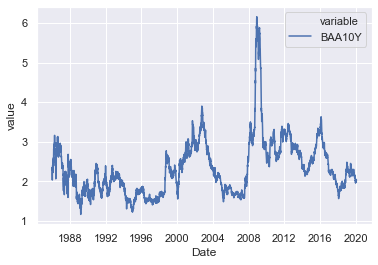

In [7]:
# Moody's
plot_data = melted_data[melted_data['variable'] == 'BAA10Y']
sns.lineplot(x='Date', y='value', hue='variable', data=plot_data)

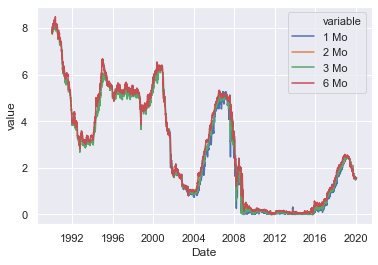

In [8]:
# Short term yields
plot_data = melted_data[melted_data['variable'].isin([x for x in cols if 'Mo' in x])]
sns.lineplot(x='Date', y='value', hue='variable', data=plot_data)

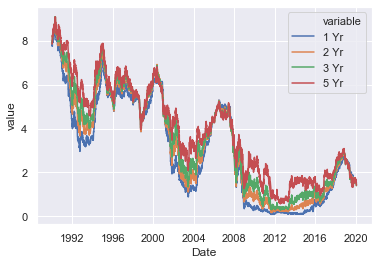

In [9]:
# Medium term yields
plot_data = melted_data[melted_data['variable'].isin(['1 Yr', '2 Yr', '3 Yr', '5 Yr'])]
sns.lineplot(x='Date', y='value', hue='variable', data=plot_data)

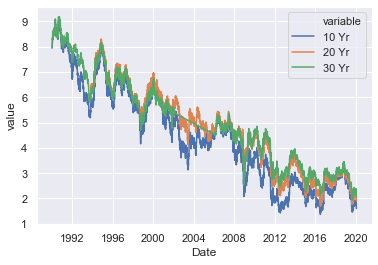

In [10]:
# Long term yields
plot_data = melted_data[melted_data['variable'].isin(['10 Yr', '20 Yr', '30 Yr'])]
sns.lineplot(x='Date', y='value', hue='variable', data=plot_data)

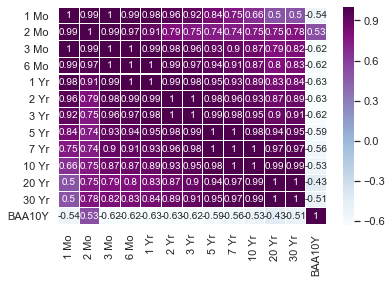

In [11]:
sns.heatmap(data.drop(['Date'], axis=1).corr(), cmap="BuPu", annot=True, linewidths=0.05)

### Missing Data

In [12]:
data.groupby(pd.Grouper(key='Date', freq='1m')).count()

,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr,BAA10Y
Date,,,,,,,,,,,,,
1986-01-31,0,0,0,0,0,0,0,0,0,0,0,0,21
1986-02-28,0,0,0,0,0,0,0,0,0,0,0,0,19
1986-03-31,0,0,0,0,0,0,0,0,0,0,0,0,20
1986-04-30,0,0,0,0,0,0,0,0,0,0,0,0,22
1986-05-31,0,0,0,0,0,0,0,0,0,0,0,0,21
1986-06-30,0,0,0,0,0,0,0,0,0,0,0,0,21
1986-07-31,0,0,0,0,0,0,0,0,0,0,0,0,22
1986-08-31,0,0,0,0,0,0,0,0,0,0,0,0,21
1986-09-30,0,0,0,0,0,0,0,0,0,0,0,0,21


## Q.2
In this question we will breakdown the dataset depending on the specefic yield we are trying to predict and the relevant time frame (next day / month / year). Pre processing and feature engineering is highly dependant on the specific task.

From the heatmap above we notice that yield vectors of close-term timespans (e.g. 5 and 7 years or 1 and 3 months) are highly correleted. Therefore, we will only train and predict on subset of yields -  3 Mo, 3 Yr, 10 Yr and BAA10Y. We will train 4 indapendant models. 

If we want to make a prediction for, i.e. 1 Yr, we will take the highest-correlated trained model, in this case the 3 Mo model. We will not demonstrate this kind of prediction in this notebook for the sake of brevity.

### Pre processing:
    1. Take 3 Mo, 1 Yr, 3 Yr, 10 Yr and BAA10Y columns.
    2. Filter from 01/01/1991 (no yield data before that)
    3. Fill NaNs with linear interpolation from nearby dates
    4. Add to each row to the yield difference from the previous day

In [13]:
data

,Date,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr,BAA10Y
0,1986-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.34
1,1986-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.30
2,1986-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.29
3,1986-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.35
4,1986-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8885,2020-01-23,1.55,1.57,1.55,1.56,1.55,1.51,1.51,1.55,1.65,1.74,2.03,2.18,1.98
8886,2020-01-24,1.54,1.55,1.54,1.55,1.55,1.49,1.48,1.51,1.61,1.70,2.00,2.14,1.98
8887,2020-01-27,1.53,1.55,1.55,1.57,1.53,1.44,1.41,1.44,1.52,1.61,1.91,2.05,2.04
8888,2020-01-28,1.53,1.57,1.57,1.58,1.53,1.45,1.45,1.47,1.56,1.65,1.95,2.10,2.04


In [14]:
prep_data = data[(data['Date'] > '1990-01-01')]
selected_cols = ['Date', '3 Mo', '3 Yr', '10 Yr', 'BAA10Y']
# selected_cols = ['3 Mo','6 Mo','1 Yr','2 Yr','3 Yr','5 Yr','7 Yr','10 Yr','30 Yr','BAA10Y']
prep_data = prep_data[selected_cols]
prep_data = prep_data.interpolate(method='linear', axis=0)

# Calculate todays diff = today's yield - yesterday's yield
prep_data_diff = prep_data.copy()
for col in prep_data_diff.columns:
    prep_data_diff[col] = prep_data[col] - prep_data[col].shift(1)
prep_data_diff = prep_data_diff[1:]

# Remove date cols
prep_data = prep_data[[col for col in prep_data.columns if 'Date' not in col]]
prep_data_diff = prep_data_diff[[col for col in prep_data_diff.columns if 'Date' not in col]]

In [15]:
prep_data

,3 Mo,3 Yr,10 Yr,BAA10Y
1043,7.83,7.90,7.94,1.91
1044,7.89,7.96,7.99,1.87
1045,7.84,7.93,7.98,1.86
1046,7.79,7.94,7.99,1.89
1047,7.79,7.95,8.02,1.86
...,...,...,...,...
8885,1.55,1.51,1.74,1.98
8886,1.54,1.48,1.70,1.98
8887,1.55,1.41,1.61,2.04
8888,1.57,1.45,1.65,2.04


In [16]:
prep_data_diff

,3 Mo,3 Yr,10 Yr,BAA10Y
1044,0.06,0.06,0.05,-0.04
1045,-0.05,-0.03,-0.01,-0.01
1046,-0.05,0.01,0.01,0.03
1047,0.00,0.01,0.03,-0.03
1048,0.01,-0.01,0.00,-0.02
...,...,...,...,...
8885,0.00,-0.01,-0.03,0.01
8886,-0.01,-0.03,-0.04,0.00
8887,0.01,-0.07,-0.09,0.06
8888,0.02,0.04,0.04,0.00


### Utility functions

In [17]:
def get_lookback(data, pos, lookback_arr):
    """
    Given a dataframe (data), an index (pos) and lookback indices (lookback_arr), this creates a ndarray with a 
    rows of the indices in lookback_arr.
    """
    columns = data.shape[1]
    res = np.zeros(shape=(len(lookback_arr), columns), dtype=np.float32)
    for i, period in enumerate(lookback_arr):
        relative = pos + period
        if relative < 0 :
            continue
        res[i] = data[relative]
    return res.reshape(-1)

def create_features(data, lookbacks=[0, -1, -2, -3, -4, -5, -6, -7], label_timespan='day', task='cls', diff=True):
    """
    Applies lookback and aggregations on the entire dataframe.
    """
    
    # Remove date column
    data = data[[col for col in data.columns if 'Date' not in col]].values
    
    rows = data.shape[0]
    columns = data.shape[1]
    num_features = columns * len(lookbacks)
    X = np.zeros(shape=(rows, num_features), dtype=np.float32)
    y = np.zeros(shape=(rows, columns), dtype=np.float32)
    for i in range(data.shape[0]):
        X[i] = get_lookback(data, i, lookbacks)
        try:
            if label_timespan == 'day':
                y[i] = data[i+1]
            elif label_timespan == 'month':
                y[i] = data[i+21]
            elif label_timespan == 'year':
                y[i] = data[i+261]
            else:
                raise ValueError("Invalid label timespan")
            if diff:
                y[i] -= data[i]
        except:
            y[i] = np.zeros(columns, dtype=np.float32)
    
    if task == 'cls':
        y[y > 0] = 1
        y[y <= 0] = 0
        y = y.astype(np.uint8)
    elif task == 'reg':
        pass
    else:
        raise ValueError("Invalid task")
        
    return X, y

def ts_train_test_split(X, y, test_frac=0.2):
    """
    Temporally splits an ordered timeseries to train-test 
    """
    split_idx = int(np.floor(X.shape[0]*(1-test_frac)))
    print("Split idx: {}".format(split_idx))
    X_train = X[:split_idx]
    X_test = X[split_idx:]
    y_train = y[:split_idx]
    y_test = y[split_idx:]
    print("X_train shape: {}, y_train shape: {}".format(X_train.shape, y_train.shape))
    print("X_test shape: {}, y_test shape: {}".format(X_test.shape, y_test.shape))
    return X_train, X_test, y_train, y_test

def train_and_test_single(model, X_train, X_test, y_train, y_test):
    """
    Trains and tests for a single-label scenario (classification)
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    print("Train report:")
    print(classification_report(y_train, y_pred))
    y_pred = model.predict(X_test)
    print("Test report:")
    print(classification_report(y_test, y_pred))
    
def train_and_test_single_reg(model, X_train, X_test, y_train, y_test):
    """
    Trains and tests for a single-label scenario (regression)
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    rmse = sklearn.metrics.mean_squared_error(y_train, y_pred)
    r2 = sklearn.metrics.r2_score(y_train, y_pred)
    ev = sklearn.metrics.explained_variance_score(y_train, y_pred)
    print("Train RMSE: {:.5f}".format(rmse))
    print("Train R-Squred: {:.5f}".format(r2))
    print("Train Explained Variance: {:.5f}".format(ev))
    y_pred = model.predict(X_test)
    rmse = sklearn.metrics.mean_squared_error(y_test, y_pred)
    r2 = sklearn.metrics.r2_score(y_test, y_pred)
    ev = sklearn.metrics.explained_variance_score(y_test, y_pred)
    print("Test RMSE: {:.5f}".format(rmse))
    print("Test R-Squred: {:.5f}".format(r2))
    print("Test Explained Variance: {:.5f}".format(ev))
    
def shuffle_together(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

### Q.2.1 - "Next day" binary classification
### Feature engineering: 
For each timestamp and each yield, compute:
    1. Yields in [t, t-1, t-2, ... , t-k] day (lookbacks) (X)
    2. A next-day indicator if the yield went up (1) or not (0) for each yield (y)
### Strategy:
For each y column, We will train a different classifier (single-label strategy). We will use all the (selected) features in the training set.

In [117]:
lookbacks = [0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21]
X, y = create_features(prep_data_diff, lookbacks=lookbacks, label_timespan='day', task='cls', diff=False)

# Train-Test Split
X_train, X_test, y_train, y_test = ts_train_test_split(X, y, test_frac=0.2)
X_train, y_train = shuffle_together(X_train, y_train)
X_test, y_test = shuffle_together(X_test, y_test)

Split idx: 6276
X_train shape: (6276, 88), y_train shape: (6276, 4)
X_test shape: (1570, 88), y_test shape: (1570, 4)


## SVM

In [118]:
from sklearn.svm import SVC as svc
param_list = [{'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'},
              {'C': .5, 'gamma': 'scale', 'kernel': 'rbf'},
              {'C': .5, 'gamma': 'scale', 'kernel': 'rbf'},
              {'C': .5, 'gamma': 'scale', 'kernel': 'rbf'}]

for i, col in enumerate(prep_data_diff.columns):
    print("***\nFitting SVM for: '{} daily'\n***".format(col))
    model = svc(**(param_list[i]))
    train_and_test_single(model, X_train, X_test, y_train[:, i], y_test[:, i])

***
Fitting SVM for: '3 Mo daily'
***
Train report:
              precision    recall  f1-score   support

           0       0.74      0.98      0.84      3910
           1       0.94      0.42      0.58      2366

    accuracy                           0.77      6276
   macro avg       0.84      0.70      0.71      6276
weighted avg       0.81      0.77      0.74      6276

Test report:
              precision    recall  f1-score   support

           0       0.65      0.99      0.78       992
           1       0.77      0.08      0.15       578

    accuracy                           0.65      1570
   macro avg       0.71      0.53      0.47      1570
weighted avg       0.69      0.65      0.55      1570

***
Fitting SVM for: '3 Yr daily'
***
Train report:
              precision    recall  f1-score   support

           0       0.58      1.00      0.73      3471
           1       0.95      0.11      0.19      2805

    accuracy                           0.60      6276
   macro av

c:\users\tom\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.61      1.00      0.76       963
           1       0.00      0.00      0.00       607

    accuracy                           0.61      1570
   macro avg       0.31      0.50      0.38      1570
weighted avg       0.38      0.61      0.47      1570



Conclusion:
Manual selection of hyperparameters (C, gamma, kernel) was made. On the best case, model collapses to random decision / majority vote.

## Logistic Regression

In [100]:
from sklearn.linear_model import LogisticRegression as lr

param_list = [{'C': 500},
              {'C': 500},
             {'C': 500},
             {'C': 500}]

for i, col in enumerate(prep_data_diff.columns):
    print("***\nFitting Logistic Regression for: '{} daily'\n***".format(col))
    model = lr(**(param_list[i]))
    train_and_test_single(model, X_train, X_test, y_train[:, i], y_test[:, i])

***
Fitting Logistic Regression for: '3 Mo daily'
***
Train report:
              precision    recall  f1-score   support

           0       0.66      0.94      0.77      3910
           1       0.66      0.20      0.31      2366

    accuracy                           0.66      6276
   macro avg       0.66      0.57      0.54      6276
weighted avg       0.66      0.66      0.60      6276

Test report:
              precision    recall  f1-score   support

           0       0.64      0.98      0.78       992
           1       0.69      0.07      0.12       578

    accuracy                           0.65      1570
   macro avg       0.67      0.52      0.45      1570
weighted avg       0.66      0.65      0.54      1570

***
Fitting Logistic Regression for: '3 Yr daily'
***
Train report:
              precision    recall  f1-score   support

           0       0.58      0.84      0.69      3471
           1       0.56      0.25      0.35      2805

    accuracy                     

Conclusion:
Manual selection of hyperparameters (C) was made, primarly to eliminate regulariztion. On the best case, model collapses to random decision / majority vote.

# XGB

In [102]:
import xgboost as xgb
param_list = [{'max_depth': 10, 'n_estimators': 400, 'learning_rate': 1e-3},
              {'max_depth': 10, 'n_estimators': 400, 'learning_rate': 1e-3},
              {'max_depth': 10, 'n_estimators': 400, 'learning_rate': 1e-3},
              {'max_depth': 10, 'n_estimators': 400, 'learning_rate': 1e-3}]

for i, col in enumerate(prep_data_diff.columns):
    print("***\nFitting XGBClassifier for: '{} daily'\n***".format(col))
    model = xgb.XGBClassifier(**(param_list[i]))
    train_and_test_single(model, X_train, X_test, y_train[:, i], y_test[:, i])

***
Fitting XGBClassifier for: '3 Mo daily'
***
Train report:
              precision    recall  f1-score   support

           0       0.83      0.99      0.90      3910
           1       0.97      0.66      0.79      2366

    accuracy                           0.87      6276
   macro avg       0.90      0.83      0.84      6276
weighted avg       0.88      0.87      0.86      6276

Test report:
              precision    recall  f1-score   support

           0       0.66      0.93      0.77       992
           1       0.58      0.16      0.25       578

    accuracy                           0.65      1570
   macro avg       0.62      0.55      0.51      1570
weighted avg       0.63      0.65      0.58      1570

***
Fitting XGBClassifier for: '3 Yr daily'
***
Train report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      3471
           1       0.98      0.80      0.88      2805

    accuracy                           0.90  

Conclusion:
Manual selection of hyperparameters (max_depth, n_estimators) was made. On the best case, model collapses to random decision/ majority vote.

### Q.2.2 - "Next month" binary classification
We use the same features as Q.2.1 only the label is one month later
### Feature engineering: 
For each timestamp and each yield, compute:
    1. Yields in [t, t-1, t-2, ... , t-k] day (lookbacks) (X)
    2. A next-month indicator if the yield went up (1) or not (0) for each yield (y)
### Strategy:
For each y column, We will train a different classifier (single-label strategy). We will use all the selected yields in the training set.

In [515]:
X, y = create_features(prep_data_diff, lookbacks=lookbacks, label_timespan='month', task='cls', diff=False)

# Train-Test Split
X_train, X_test, y_train, y_test = ts_train_test_split(X, y, test_frac=0.25)

Split idx: 5884
X_train shape: (5884, 88), y_train shape: (5884, 4)
X_test shape: (1962, 88), y_test shape: (1962, 4)


## SVM

In [519]:
from sklearn.svm import SVC as svc
param_list = [{'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'},
              {'C': .5, 'gamma': 'scale', 'kernel': 'rbf'},
              {'C': .5, 'gamma': 'scale', 'kernel': 'rbf'},
              {'C': .5, 'gamma': 'scale', 'kernel': 'rbf'}]

for i, col in enumerate(prep_data_diff.columns):
    print("***\nFitting SVM for: '{} monthly'\n***".format(col))
    model = svc(**(param_list[i]))
    train_and_test_single(model, X_train, X_test, y_train[:, i], y_test[:, i])

***
Fitting SVM for: '3 Mo_diff monthly'
***
Train report:
              precision    recall  f1-score   support

           0       0.72      0.98      0.83      3622
           1       0.94      0.39      0.55      2262

    accuracy                           0.75      5884
   macro avg       0.83      0.68      0.69      5884
weighted avg       0.80      0.75      0.72      5884

Test report:
              precision    recall  f1-score   support

           0       0.66      0.99      0.80      1288
           1       0.70      0.04      0.08       674

    accuracy                           0.66      1962
   macro avg       0.68      0.52      0.44      1962
weighted avg       0.68      0.66      0.55      1962

***
Fitting SVM for: '3 Yr_diff monthly'
***
Train report:
              precision    recall  f1-score   support

           0       0.56      1.00      0.72      3228
           1       1.00      0.05      0.10      2656

    accuracy                           0.57      58

C:\Users\Tom\Miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train report:
              precision    recall  f1-score   support

           0       0.56      1.00      0.72      3260
           1       1.00      0.03      0.05      2624

    accuracy                           0.57      5884
   macro avg       0.78      0.51      0.39      5884
weighted avg       0.76      0.57      0.42      5884

Test report:
              precision    recall  f1-score   support

           0       0.57      1.00      0.73      1125
           1       0.00      0.00      0.00       837

    accuracy                           0.57      1962
   macro avg       0.29      0.50      0.36      1962
weighted avg       0.33      0.57      0.42      1962

***
Fitting SVM for: 'BAA10Y_diff monthly'
***


C:\Users\Tom\Miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train report:
              precision    recall  f1-score   support

           0       0.59      1.00      0.74      3476
           1       1.00      0.01      0.01      2408

    accuracy                           0.59      5884
   macro avg       0.80      0.50      0.38      5884
weighted avg       0.76      0.59      0.44      5884

Test report:
              precision    recall  f1-score   support

           0       0.63      1.00      0.77      1229
           1       0.00      0.00      0.00       733

    accuracy                           0.63      1962
   macro avg       0.31      0.50      0.39      1962
weighted avg       0.39      0.63      0.48      1962



C:\Users\Tom\Miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Conclusion:
Manual selection of hyperparameters (C, gamma, kernel) was made. On the best case, model collapses to majority vote.

## Logistic Regression

In [520]:
from sklearn.linear_model import LogisticRegression as lr
param_list = [{'C': 500},
              {'C': 500},
             {'C': 500},
             {'C': 500}]

for i, col in enumerate(prep_data_diff.columns):
    print("***\nFitting Logistic Regression for: '{} monthly'\n***".format(col))
    model = lr(**(param_list[i]))
    train_and_test_single(model, X_train, X_test, y_train[:, i], y_test[:, i])

***
Fitting Logistic Regression for: '3 Mo_diff monthly'
***
Train report:
              precision    recall  f1-score   support

           0       0.65      0.93      0.77      3622
           1       0.64      0.20      0.30      2262

    accuracy                           0.65      5884
   macro avg       0.65      0.56      0.53      5884
weighted avg       0.65      0.65      0.59      5884

Test report:
              precision    recall  f1-score   support

           0       0.66      0.99      0.79      1288
           1       0.63      0.05      0.09       674

    accuracy                           0.66      1962
   macro avg       0.65      0.52      0.44      1962
weighted avg       0.65      0.66      0.55      1962

***
Fitting Logistic Regression for: '3 Yr_diff monthly'
***
Train report:
              precision    recall  f1-score   support

           0       0.57      0.84      0.68      3228
           1       0.56      0.24      0.34      2656

    accuracy       

Conclusion:
Manual selection of hyperparameters (C) was made, primarly to eliminate regulariztion. On the best case, model collapses to majority vote.

# XGB

In [521]:
import xgboost as xgb
param_list = [{'max_depth': 10, 'n_estimators': 400, 'learning_rate': 1e-3},
              {'max_depth': 10, 'n_estimators': 400, 'learning_rate': 1e-3},
              {'max_depth': 10, 'n_estimators': 400, 'learning_rate': 1e-3},
              {'max_depth': 10, 'n_estimators': 400, 'learning_rate': 1e-3}]

for i, col in enumerate(prep_data_diff.columns):
    print("***\nFitting XGBClassifier for: '{} monthly'\n***".format(col))
    model = xgb.XGBClassifier(**(param_list[i]))
    train_and_test_single(model, X_train, X_test, y_train[:, i], y_test[:, i])

***
Fitting XGBClassifier for: '3 Mo_diff monthly'
***
Train report:
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      3622
           1       0.98      0.69      0.81      2262

    accuracy                           0.88      5884
   macro avg       0.91      0.84      0.86      5884
weighted avg       0.89      0.88      0.87      5884

Test report:
              precision    recall  f1-score   support

           0       0.69      0.92      0.79      1288
           1       0.56      0.20      0.30       674

    accuracy                           0.67      1962
   macro avg       0.63      0.56      0.54      1962
weighted avg       0.65      0.67      0.62      1962

***
Fitting XGBClassifier for: '3 Yr_diff monthly'
***
Train report:
              precision    recall  f1-score   support

           0       0.69      0.99      0.81      3228
           1       0.98      0.45      0.62      2656

    accuracy                   

Conclusion:
Manual selection of hyperparameters (max_depth, n_estimators) was made. On the best case, model collapses to random decision/ majority vote.

### Q.2.3 - "Next year" binary classification
We use the same features as Q.2.1 only the label is one year later.
### Feature engineering: 
For each timestamp and each yield, compute:
    1. Yields in [t, t-1, t-2, ... , t-k] day (lookbacks) (X)
    2. A next-year indicator if the yield went up (1) or not (0) for each yield (y)
### Strategy:
For each y column, We will train a different classifier (single-label strategy). We will use all the selected yields in the training set.

In [79]:
lookbacks = [0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21]
X, y = create_features(prep_data_diff, lookbacks=lookbacks, label_timespan='year', task='cls', diff=False)

# Train-Test Split
X_train, X_test, y_train, y_test = ts_train_test_split(X, y, test_frac=0.2)

Split idx: 6276
X_train shape: (6276, 88), y_train shape: (6276, 4)
X_test shape: (1570, 88), y_test shape: (1570, 4)


## SVM

In [158]:
from sklearn.svm import SVC as svc
param_list = [{'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'},
              {'C': .5, 'gamma': 'scale', 'kernel': 'rbf'},
              {'C': .5, 'gamma': 'scale', 'kernel': 'rbf'},
              {'C': .5, 'gamma': 'scale', 'kernel': 'rbf'}]

for i, col in enumerate(prep_data_diff.columns):
    print("***\nFitting SVM for: '{} yearly'\n***".format(col))
    model = svc(**(param_list[i]))
    train_and_test_single(model, X_train, X_test, y_train[:, i], y_test[:, i])

***
Fitting SVM for: '3 Mo monthly'
***
Train report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      2375
           1       0.93      0.98      0.96      3509

    accuracy                           0.95      5884
   macro avg       0.95      0.94      0.94      5884
weighted avg       0.95      0.95      0.95      5884

Test report:
              precision    recall  f1-score   support

           0       0.27      0.21      0.24       542
           1       0.72      0.79      0.75      1420

    accuracy                           0.63      1962
   macro avg       0.50      0.50      0.49      1962
weighted avg       0.60      0.63      0.61      1962

***
Fitting SVM for: '3 Yr monthly'
***
Train report:
              precision    recall  f1-score   support

           0       0.87      0.33      0.47      2700
           1       0.63      0.96      0.76      3184

    accuracy                           0.67      5884
   macr

Conclusion:
Manual selection of hyperparameters (C, gamma, kernel) was made. On the best case, model collapses to majority vote.

## Logistic Regression

In [159]:
from sklearn.linear_model import LogisticRegression as lr
param_list = [{'C': 500},
              {'C': 500},
             {'C': 500},
             {'C': 500}]

for i, col in enumerate(prep_data_diff.columns):
    print("***\nFitting Logistic Regression for: '{} yearly'\n***".format(col))
    model = lr(**(param_list[i]))
    train_and_test_single(model, X_train, X_test, y_train[:, i], y_test[:, i])

***
Fitting Logistic Regression for: '3 Mo monthly'
***
Train report:
              precision    recall  f1-score   support

           0       0.61      0.03      0.05      2375
           1       0.60      0.99      0.75      3509

    accuracy                           0.60      5884
   macro avg       0.60      0.51      0.40      5884
weighted avg       0.60      0.60      0.47      5884

Test report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       542
           1       0.72      1.00      0.84      1420

    accuracy                           0.72      1962
   macro avg       0.36      0.50      0.42      1962
weighted avg       0.52      0.72      0.61      1962

***
Fitting Logistic Regression for: '3 Yr monthly'
***
Train report:
              precision    recall  f1-score   support

           0       0.53      0.04      0.07      2700
           1       0.54      0.97      0.70      3184

    accuracy                 

C:\Users\Tom\Miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Tom\Miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Conclusion:
Manual selection of hyperparameters (C) was made. LR performs poorly.

# XGB

In [522]:
import xgboost as xgb
param_list = [{'max_depth': 10, 'n_estimators': 400, 'learning_rate': 1e-3},
              {'max_depth': 10, 'n_estimators': 400, 'learning_rate': 1e-3},
              {'max_depth': 10, 'n_estimators': 400, 'learning_rate': 1e-3},
              {'max_depth': 10, 'n_estimators': 400, 'learning_rate': 1e-3}]

for i, col in enumerate(prep_data_diff.columns):
    print("***\nFitting XGBClassifier for: '{} yearly'\n***".format(col))
    model = xgb.XGBClassifier(**(param_list[i]))
    train_and_test_single(model, X_train, X_test, y_train[:, i], y_test[:, i])

***
Fitting XGBClassifier for: '3 Mo_diff yearly'
***
Train report:
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      3622
           1       0.98      0.69      0.81      2262

    accuracy                           0.88      5884
   macro avg       0.91      0.84      0.86      5884
weighted avg       0.89      0.88      0.87      5884

Test report:
              precision    recall  f1-score   support

           0       0.69      0.92      0.79      1288
           1       0.56      0.20      0.30       674

    accuracy                           0.67      1962
   macro avg       0.63      0.56      0.54      1962
weighted avg       0.65      0.67      0.62      1962

***
Fitting XGBClassifier for: '3 Yr_diff yearly'
***
Train report:
              precision    recall  f1-score   support

           0       0.69      0.99      0.81      3228
           1       0.98      0.45      0.62      2656

    accuracy                     

Conclusion:
Manual selection of hyperparameters (max_depth, n_estimators) was made. On the best case, model collapses to random decision/ majority vote.

## Q.3
In this question we will create a processed dataset similar to the one in Q.2 only that we will keep the actual yield values (instead of the diff from yesterday)

We will only predict for a "next-day" scenario for the sake of brevity.

In [179]:
lookbacks = [0, -1, -2, -3, -4, -5, -6]
# lookbacks = [0]
X, y = create_features(prep_data, lookbacks=lookbacks, label_timespan='day', task='reg', diff=False)

# Train-Test Split
X_train, X_test, y_train, y_test = ts_train_test_split(X, y, test_frac=0.2)
X_train, y_train = shuffle_together(X_train, y_train)
X_test, y_test = shuffle_together(X_test, y_test)

Split idx: 6277
X_train shape: (6277, 28), y_train shape: (6277, 4)
X_test shape: (1570, 28), y_test shape: (1570, 4)


# Linear Regression

In [180]:
import statsmodels.api as sm
for i, col in enumerate(prep_data.columns):
    print("***\nFitting Linear Regression for: '{} daily'\n***".format(col))
    model = sm.OLS(y_train[:, i], sm.add_constant(X_train, prepend=False))
    res = model.fit()
    print(res.summary())
    y_pred = res.predict(sm.add_constant(X_test, prepend=False))
    rmse = sklearn.metrics.mean_squared_error(y_test[:, i], y_pred)
    r2 = sklearn.metrics.r2_score(y_test[:, i], y_pred)
    ev = sklearn.metrics.explained_variance_score(y_test[:, i], y_pred)
    print("Test RMSE: {:.5f}".format(rmse))
    print("Test R-Squred: {:.5f}".format(r2))
    print("Test Explained Variance: {:.5f}".format(ev))

***
Fitting Linear Regression for: '3 Mo daily'
***
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.002e+05
Date:                Sun, 09 Feb 2020   Prob (F-statistic):               0.00
Time:                        15:29:53   Log-Likelihood:                 10111.
No. Observations:                6277   AIC:                        -2.016e+04
Df Residuals:                    6248   BIC:                        -1.997e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


strong multicollinearity or other numerical problems.
Test RMSE: 0.00255
Test R-Squred: 0.99403
Test Explained Variance: 0.99407
***
Fitting Linear Regression for: '10 Yr daily'
***
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.051e+05
Date:                Sun, 09 Feb 2020   Prob (F-statistic):               0.00
Time:                        15:29:53   Log-Likelihood:                 8960.3
No. Observations:                6277   AIC:                        -1.786e+04
Df Residuals:                    6248   BIC:                        -1.767e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std

strong multicollinearity or other numerical problems.
Test RMSE: 0.00306
Test R-Squred: 0.98369
Test Explained Variance: 0.98370


Conclusion:
Linear regression preforms pretty well, we suspect that the predicted value of tomorrow is almost equal to the value of toay (x1 coeff is nearly 1.0).

# SVR

In [181]:
from sklearn.svm import SVR as svr
param_list = [{'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'},
              {'C': .5, 'gamma': 'scale', 'kernel': 'rbf'},
              {'C': .5, 'gamma': 'scale', 'kernel': 'rbf'},
              {'C': .5, 'gamma': 'scale', 'kernel': 'rbf'}]

for i, col in enumerate(prep_data.columns):
    print("***\nFitting SVR for: '{} daily'\n***".format(col))
    model = svr(**(param_list[i]))
    train_and_test_single_reg(model, X_train, X_test, y_train[:, i], y_test[:, i])

***
Fitting SVR for: '3 Mo daily'
***
Train RMSE: 0.00794
Train R-Squred: 0.99848
Train Explained Variance: 0.99849
Test RMSE: 0.01532
Test R-Squred: 0.98027
Test Explained Variance: 0.99400
***
Fitting SVR for: '3 Yr daily'
***
Train RMSE: 0.01086
Train R-Squred: 0.99784
Train Explained Variance: 0.99784
Test RMSE: 0.01896
Test R-Squred: 0.95560
Test Explained Variance: 0.95645
***
Fitting SVR for: '10 Yr daily'
***
Train RMSE: 0.00802
Train R-Squred: 0.99741
Train Explained Variance: 0.99741
Test RMSE: 0.04806
Test R-Squred: 0.72580
Test Explained Variance: 0.85905
***
Fitting SVR for: 'BAA10Y daily'
***
Train RMSE: 0.00286
Train R-Squred: 0.99552
Train Explained Variance: 0.99565
Test RMSE: 0.01420
Test R-Squred: 0.92425
Test Explained Variance: 0.96114


Conclusion:
various hyperparameters were used. SVR preforms ok.

# Random Forest Regressor

In [182]:
from sklearn.ensemble import RandomForestRegressor as rfr
param_list = [{'n_estimators': 100, 'max_depth': 20},
              {'n_estimators': 100, 'max_depth': 20},
              {'n_estimators': 100, 'max_depth': 20},
              {'n_estimators': 100, 'max_depth': 20}]

for i, col in enumerate(prep_data.columns):
    print("***\nFitting Random Forest Regressor for: '{} daily'\n***".format(col))
    model = rfr()
    train_and_test_single_reg(model, X_train, X_test, y_train[:, i], y_test[:, i])

***
Fitting Random Forest Regressor for: '3 Mo daily'
***
Train RMSE: 0.00039
Train R-Squred: 0.99993
Train Explained Variance: 0.99993
Test RMSE: 0.00515
Test R-Squred: 0.99336
Test Explained Variance: 0.99336
***
Fitting Random Forest Regressor for: '3 Yr daily'
***
Train RMSE: 0.00056
Train R-Squred: 0.99989
Train Explained Variance: 0.99989
Test RMSE: 0.00389
Test R-Squred: 0.99089
Test Explained Variance: 0.99094
***
Fitting Random Forest Regressor for: '10 Yr daily'
***
Train RMSE: 0.00054
Train R-Squred: 0.99983
Train Explained Variance: 0.99983
Test RMSE: 0.00737
Test R-Squred: 0.95798
Test Explained Variance: 0.95848
***
Fitting Random Forest Regressor for: 'BAA10Y daily'
***
Train RMSE: 0.00016
Train R-Squred: 0.99975
Train Explained Variance: 0.99975
Test RMSE: 0.00338
Test R-Squred: 0.98197
Test Explained Variance: 0.98198


Conclusion:
various hyperparameters were used. RFR performs ok.

## Q.4
In this question we will create a processed dataset similar to the one in Q.3. We will only predict for a "next-day" scenario for the sake of brevity.

In [18]:
import torch
import torch.nn as nn

In [19]:
# lookbacks = [-x for x in range(100)]
# lookbacks = [0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21]
lookbacks = [0, -1, -2, -3, -4, -5, -6]
X, y = create_features(prep_data, lookbacks=lookbacks, label_timespan='day', task='reg', diff=False)

X_train, X_test, y_train, y_test = ts_train_test_split(X, y, test_frac=0.2)

X_train = np.reshape(X_train, (-1, len(lookbacks), 4))
X_test = np.reshape(X_test, (-1, len(lookbacks), 4))

X_train, X_test, y_train, y_test = torch.FloatTensor(X_train), torch.FloatTensor(X_test), torch.FloatTensor(y_train), torch.FloatTensor(y_test)
    
train_set = list(zip(X_train, y_train))
test_set = list(zip(X_test, y_test))

Split idx: 6277
X_train shape: (6277, 28), y_train shape: (6277, 4)
X_test shape: (1570, 28), y_test shape: (1570, 4)


In [29]:
class LSTM(nn.Module):
    def __init__(self, input_size=4, hidden_layer_size=5, output_size=4):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size), torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [30]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
print(model)

LSTM(
  (lstm): LSTM(4, 5)
  (linear): Linear(in_features=5, out_features=4, bias=True)
)


In [ ]:
epochs = 10

train_epoch_loss, test_epoch_loss = 0.0, 0.0
for i in range(epochs):
    model.train()
    for j, (seq, labels) in enumerate(train_set):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size), torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
        train_epoch_loss += single_loss.item()
    print('epoch: {:03d} avg train epoch loss: {:.6f}'.format(i+1, train_epoch_loss/len(train_set)))
    train_epoch_loss = 0.0
    
    model.eval()
    for j, (seq, labels) in enumerate(test_set):
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        test_epoch_loss += single_loss.item()
    print('epoch: {:03d} avg test epoch loss: {:.6f}'.format(i+1, test_epoch_loss/len(test_set)))
    test_epoch_loss = 0.0

epoch: 001 avg train epoch loss: 1.153179
epoch: 001 avg test epoch loss: 0.449519
epoch: 002 avg train epoch loss: 0.923544
epoch: 002 avg test epoch loss: 0.369824
epoch: 003 avg train epoch loss: 0.755422
epoch: 003 avg test epoch loss: 0.330575
epoch: 004 avg train epoch loss: 0.642752
epoch: 004 avg test epoch loss: 0.315463
epoch: 005 avg train epoch loss: 0.565234
epoch: 005 avg test epoch loss: 0.313567
epoch: 006 avg train epoch loss: 0.510515
epoch: 006 avg test epoch loss: 0.319256
epoch: 007 avg train epoch loss: 0.470721
epoch: 007 avg test epoch loss: 0.328909
epoch: 008 avg train epoch loss: 0.440811
epoch: 008 avg test epoch loss: 0.339765
epoch: 009 avg train epoch loss: 0.417542
epoch: 009 avg test epoch loss: 0.350202


Conclusion: we trained a basic LSTM neural network that given a 7 day lookback, predicts the next day (3 Mo, 3 Yr, 10 Yr, BAA10Y) vector. Different parameters were tested. We kept a small hidden state size to avoid overfitting. Train and test loss gradually decline.... until overfitting :)